In [1]:
import numpy as np
import pandas as pd
import openpyxl
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.sandbox.stats.multicomp import MultiComparison


# Read file

In [2]:
file_path = "Processed Chocolate.xlsx"
df = pd.read_excel(file_path)  

# Find bad data

In [3]:
# Count how many times each participant code appears
counts = df.groupby("Participant Code").size().reset_index(name="count")

# Pick out the ones that are NOT repeated exactly 4 times
bad_codes = counts[counts["count"] != 4]

print(bad_codes)

     Participant Code  count
29               1033      3
88               1118      1
90               1126      1
91               1128      1
92               2005      3
99               2013      1
104              2018      2
105              2019      2
106              2020      3
110              2025      2
114              2029      2
115              2030      2
119              2034      1
120              2035      3
121              2036      2


# Keep participants with complete submissions only

In [4]:
# Count occurrences
counts = df["Participant Code"].value_counts()

# Keep only codes that appear exactly 4 times
good_codes = counts[counts == 4].index

# Filter the original dataframe
df_clean = df[df["Participant Code"].isin(good_codes)].copy()

print(df_clean.head())
print(len(df), "rows before →", len(df_clean), "rows after")


   Participant Code                                       Sample Name  \
0              1002  Whittaker's Creamy Milk 33% Cocoa Milk Chocolate   
1              1002   Whittaker's Dark Block 50% Cocoa Dark Chocolate   
2              1002   Whittaker's Dark Cacao 62% Cocoa Dark Chocolate   
3              1002   Whittaker's Dark Ghana 72% Cocoa Dark Chocolate   
4              1003  Whittaker's Creamy Milk 33% Cocoa Milk Chocolate   

   Overall  Aroma  Flavour  Texture  Aftertaste like_comments  \
0        2      2        2        6           1           NaN   
1        8      8        9        5           8           NaN   
2        7      6        7        5           9           NaN   
3        4      4        4        7           5           NaN   
4        8      7        8        7           7           NaN   

  dislike_comments  purchase_intent  willingness_to_pay  
0              NaN                5                 NaN  
1              NaN                1                 7.

In [5]:
codes_to_drop = [1034, 2014]

# Drop them
df_clean = df_clean[~df_clean["Participant Code"].isin(codes_to_drop)].reset_index(drop=True)

print(len(df), "rows before →", len(df_clean), "rows after")

469 rows before → 432 rows after


# Check total participants after cleaning

In [6]:
unique_count = df_clean["Participant Code"].nunique()
print("Number of unique participant codes:", unique_count)

Number of unique participant codes: 108


# F-value

In [7]:
df_clean = df_clean.rename(columns={"Sample Name": "Sample_Name"})

model = ols("Overall ~ C(Sample_Name)", data=df_clean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                     sum_sq     df          F        PR(>F)
C(Sample_Name)   165.581019    3.0  14.231531  7.409819e-09
Residual        1659.898148  428.0        NaN           NaN


# Check number of submission for each chocolate type

In [8]:
df.columns = df.columns.str.strip().str.replace(' ', '_')

In [9]:
df_clean['Overall'] = pd.to_numeric(df['Overall'], errors='coerce')
df_clean = df_clean.dropna(subset=['Overall']) 

In [10]:
counts = df_clean['Sample_Name'].value_counts().sort_index()
print(counts.head(16))          
print("\nSummary of counts (how many samples have N replicates):\n", counts.value_counts().sort_index())

Sample_Name
Whittaker's Creamy Milk 33% Cocoa Milk Chocolate    108
Whittaker's Dark Block 50% Cocoa Dark Chocolate     108
Whittaker's Dark Cacao 62% Cocoa Dark Chocolate     108
Whittaker's Dark Ghana 72% Cocoa Dark Chocolate     108
Name: count, dtype: int64

Summary of counts (how many samples have N replicates):
 count
108    4
Name: count, dtype: int64


# Mean and SD

In [11]:
name_map = {
    "Whittaker's Creamy Milk 33% Cocoa Milk Chocolate": "33% Milk Chocolate",
    "Whittaker's Dark Block 50% Cocoa Dark Chocolate": "50% Dark Chocolate",
    "Whittaker's Dark Cacao 62% Cocoa Dark Chocolate": "62% Dark Chocolate",
    "Whittaker's Dark Ghana 72% Cocoa Dark Chocolate": "72% Dark Chocolate"
}

## Overall

In [12]:
df_overall = df_clean.groupby("Sample_Name", as_index=False).agg(
    Mean_Overall=("Overall", "mean"),
    Std_Overall=("Overall", "std"),
    N_Overall=("Overall", "count")
)

# Apply mapping
df_overall["Short_Name"] = df_overall["Sample_Name"].map(name_map)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

print(df_overall)
print("Number of unique samples:", len(df_overall))

                                        Sample_Name  Mean_Overall  Std_Overall  N_Overall          Short_Name
0  Whittaker's Creamy Milk 33% Cocoa Milk Chocolate      6.500000     2.115806        108  33% Milk Chocolate
1   Whittaker's Dark Block 50% Cocoa Dark Chocolate      6.814815     1.740921        108  50% Dark Chocolate
2   Whittaker's Dark Cacao 62% Cocoa Dark Chocolate      6.055556     2.152301        108  62% Dark Chocolate
3   Whittaker's Dark Ghana 72% Cocoa Dark Chocolate      6.351852     2.167365        108  72% Dark Chocolate
Number of unique samples: 4


## Aroma

In [13]:
df_aroma = df_clean.groupby("Sample_Name", as_index=False).agg(
    Mean_Aroma=("Aroma", "mean"),
    Std_Aroma=("Aroma", "std"),
    N_Aroma=("Aroma", "count")
)

df_aroma["Short_Name"] = df_aroma["Sample_Name"].map(name_map)
pd.set_option("display.max_columns", None)   # show all columns
pd.set_option("display.width", 1000)         # set max width for wrapping

print(df_aroma)

                                        Sample_Name  Mean_Aroma  Std_Aroma  N_Aroma          Short_Name
0  Whittaker's Creamy Milk 33% Cocoa Milk Chocolate    6.500000   1.862066      108  33% Milk Chocolate
1   Whittaker's Dark Block 50% Cocoa Dark Chocolate    6.750000   1.428188      108  50% Dark Chocolate
2   Whittaker's Dark Cacao 62% Cocoa Dark Chocolate    6.342593   1.647213      108  62% Dark Chocolate
3   Whittaker's Dark Ghana 72% Cocoa Dark Chocolate    5.731481   1.837341      108  72% Dark Chocolate


## Flavour

In [14]:
df_flavour = df_clean.groupby("Sample_Name", as_index=False).agg(
    Mean_Flavour=("Flavour", "mean"),
    Std_Flavour=("Flavour", "std"),
    N_Flavour=("Flavour", "count"))

df_flavour["Short_Name"] = df_flavour["Sample_Name"].map(name_map)
pd.set_option("display.max_columns", None)   # show all columns
pd.set_option("display.width", 1000)         # set max width for wrapping

print(df_flavour)

                                        Sample_Name  Mean_Flavour  Std_Flavour  N_Flavour          Short_Name
0  Whittaker's Creamy Milk 33% Cocoa Milk Chocolate      6.583333     2.175157        108  33% Milk Chocolate
1   Whittaker's Dark Block 50% Cocoa Dark Chocolate      6.907407     1.671851        108  50% Dark Chocolate
2   Whittaker's Dark Cacao 62% Cocoa Dark Chocolate      6.611111     1.662300        108  62% Dark Chocolate
3   Whittaker's Dark Ghana 72% Cocoa Dark Chocolate      5.388889     2.266511        108  72% Dark Chocolate


## Texture

In [15]:
df_texture = df_clean.groupby("Sample_Name", as_index=False).agg(
    Mean_Texture=("Texture", "mean"),
    Std_Texture=("Texture", "std"),
    N_Texture=("Texture", "count"))

df_texture["Short_Name"] = df_texture["Sample_Name"].map(name_map)
pd.set_option("display.max_columns", None)   # show all columns
pd.set_option("display.width", 1000)         # set max width for wrapping

print(df_texture)

                                        Sample_Name  Mean_Texture  Std_Texture  N_Texture          Short_Name
0  Whittaker's Creamy Milk 33% Cocoa Milk Chocolate      7.240741     1.662508        108  33% Milk Chocolate
1   Whittaker's Dark Block 50% Cocoa Dark Chocolate      7.111111     1.429550        108  50% Dark Chocolate
2   Whittaker's Dark Cacao 62% Cocoa Dark Chocolate      6.731481     1.655388        108  62% Dark Chocolate
3   Whittaker's Dark Ghana 72% Cocoa Dark Chocolate      5.944444     1.903432        108  72% Dark Chocolate


## Aftertaste

In [16]:
df_aftertaste = df_clean.groupby("Sample_Name", as_index=False).agg(
    Mean_Aftertaste=("Aftertaste", "mean"),
    Std_Aftertaste=("Aftertaste", "std"),
    N_Aftertaste=("Aftertaste", "count"))

df_aftertaste["Short_Name"] = df_aftertaste["Sample_Name"].map(name_map)
pd.set_option("display.max_columns", None)   # show all columns
pd.set_option("display.width", 1000)         # set max width for wrapping

print(df_aftertaste)

                                        Sample_Name  Mean_Aftertaste  Std_Aftertaste  N_Aftertaste          Short_Name
0  Whittaker's Creamy Milk 33% Cocoa Milk Chocolate         6.750000        2.105289           108  33% Milk Chocolate
1   Whittaker's Dark Block 50% Cocoa Dark Chocolate         6.731481        1.609589           108  50% Dark Chocolate
2   Whittaker's Dark Cacao 62% Cocoa Dark Chocolate         6.296296        2.001211           108  62% Dark Chocolate
3   Whittaker's Dark Ghana 72% Cocoa Dark Chocolate         5.000000        2.426489           108  72% Dark Chocolate


# ANOVA table

## Overall

In [17]:
model = ols("Overall ~ C(Sample_Name)", data=df_clean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)   # Type II ANOVA
print("ANOVA results:")
print(anova_table)


ANOVA results:
                     sum_sq     df         F    PR(>F)
C(Sample_Name)    32.324074    3.0  2.559717  0.054555
Residual        1801.592593  428.0       NaN       NaN


In [57]:
groups = [df_clean[df_clean["Sample_Name"] == choc]["Overall"] 
          for choc in df_clean["Sample_Name"].unique()]

f_stat, p_val = stats.f_oneway(*groups)
print("Overall ANOVA F-statistic:", f_stat)
print("Overall ANOVA p-value:", p_val)

Overall ANOVA F-statistic: 2.5597173968162608
Overall ANOVA p-value: 0.05455532713925412


## Aroma

In [58]:
model = ols("Aroma ~ C(Sample_Name)", data=df_clean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)   # Type II ANOVA
print("ANOVA results:")
print(anova_table)

ANOVA results:
                     sum_sq     df         F    PR(>F)
C(Sample_Name)    60.877315    3.0  6.999721  0.000132
Residual        1240.787037  428.0       NaN       NaN


In [96]:
groups = [df_clean[df_clean["Sample_Name"] == choc]["Aroma"] 
          for choc in df_clean["Sample_Name"].unique()]

f_stat, p_val = stats.f_oneway(*groups)
print("Overall ANOVA F-statistic:", f_stat)
print("Overall ANOVA p-value:", p_val)

Overall ANOVA F-statistic: 6.999721403430221
Overall ANOVA p-value: 0.00013216430523575235


## Flavour

In [97]:
model = ols("Flavour ~ C(Sample_Name)", data=df_clean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)   # Type II ANOVA
print("ANOVA results:")
print(anova_table)

ANOVA results:
                     sum_sq     df          F        PR(>F)
C(Sample_Name)   146.340278    3.0  12.648221  6.169117e-08
Residual        1650.657407  428.0        NaN           NaN


In [134]:
groups = [df_clean[df_clean["Sample_Name"] == choc]["Flavour"] 
          for choc in df_clean["Sample_Name"].unique()]

f_stat, p_val = stats.f_oneway(*groups)
print("Overall ANOVA F-statistic:", f_stat)
print("Overall ANOVA p-value:", p_val)

Overall ANOVA F-statistic: 12.648220966954808
Overall ANOVA p-value: 6.169116980505567e-08


## Texture

In [135]:
model = ols("Texture ~ C(Sample_Name)", data=df_clean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)   # Type II ANOVA
print("ANOVA results:")
print(anova_table)

ANOVA results:
                     sum_sq     df          F        PR(>F)
C(Sample_Name)   110.192130    3.0  13.152275  3.136649e-08
Residual        1195.287037  428.0        NaN           NaN


In [171]:
groups = [df_clean[df_clean["Sample_Name"] == choc]["Texture"] 
          for choc in df_clean["Sample_Name"].unique()]

f_stat, p_val = stats.f_oneway(*groups)
print("Overall ANOVA F-statistic:", f_stat)
print("Overall ANOVA p-value:", p_val)

Overall ANOVA F-statistic: 13.152275010134966
Overall ANOVA p-value: 3.136648936234692e-08


## Aftertaste

In [172]:
model = ols("Aftertaste ~ C(Sample_Name)", data=df_clean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)   # Type II ANOVA
print("ANOVA results:")
print(anova_table)

ANOVA results:
                     sum_sq     df          F        PR(>F)
C(Sample_Name)   219.685185    3.0  17.316063  1.250486e-10
Residual        1809.981481  428.0        NaN           NaN


In [207]:
groups = [df_clean[df_clean["Sample_Name"] == choc]["Aftertaste"] 
          for choc in df_clean["Sample_Name"].unique()]

f_stat, p_val = stats.f_oneway(*groups)
print("Overall ANOVA F-statistic:", f_stat)
print("Overall ANOVA p-value:", p_val)

Overall ANOVA F-statistic: 17.316062847652077
Overall ANOVA p-value: 1.250486327565028e-10


# Tukey pairwise test

## Overall

In [208]:
tukey = pairwise_tukeyhsd(endog=df_clean["Overall"], #endog means endogenous variables.
                          groups=df_clean["Sample_Name"],
                          alpha=0.05)

print("\nTukey HSD results:")
print(tukey.summary())



Tukey HSD results:
                                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                                          
                     group1                                           group2                     meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------------------------------------------------------------------
Whittaker's Creamy Milk 33% Cocoa Milk Chocolate Whittaker's Dark Block 50% Cocoa Dark Chocolate   0.3148 0.6727 -0.4053  1.0349  False
Whittaker's Creamy Milk 33% Cocoa Milk Chocolate Whittaker's Dark Cacao 62% Cocoa Dark Chocolate  -0.4444 0.3843 -1.1645  0.2756  False
Whittaker's Creamy Milk 33% Cocoa Milk Chocolate Whittaker's Dark Ghana 72% Cocoa Dark Chocolate  -0.1481 0.9516 -0.8682  0.5719  False
 Whittaker's Dark Block 50% Cocoa Dark Chocolate Whittaker's Dark Cacao 62% Cocoa Dark Chocolate  -0.7593 0.0342 -1.4793 -0.0392   True
 Whittaker's Dark Block 50% 

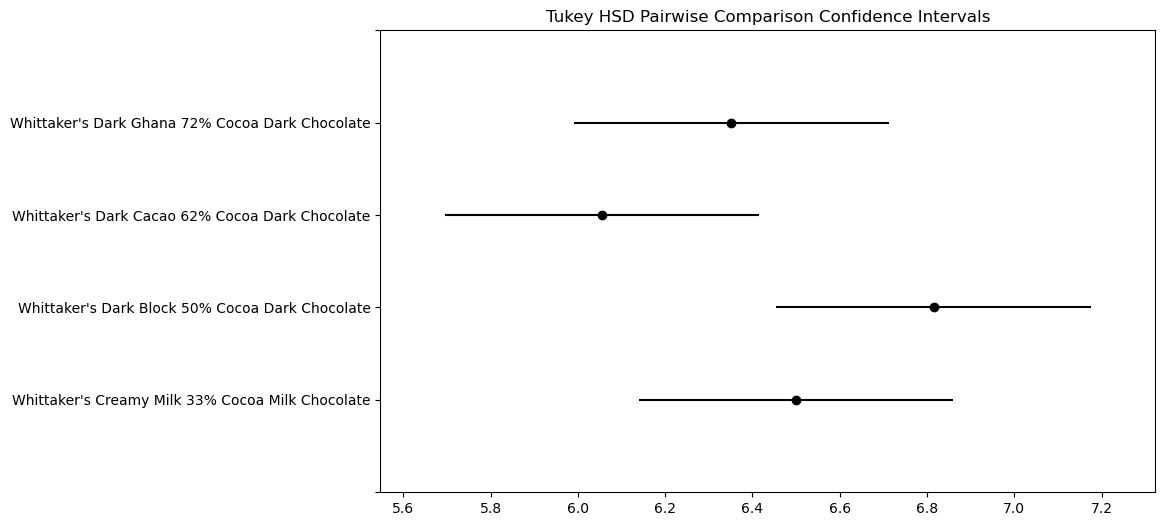

In [209]:
tukey.plot_simultaneous()
plt.title("Tukey HSD Pairwise Comparison Confidence Intervals")
plt.show()

## Aroma


Tukey HSD results:
                                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                                          
                     group1                                           group2                     meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------------------------------------------------------------------
Whittaker's Creamy Milk 33% Cocoa Milk Chocolate Whittaker's Dark Block 50% Cocoa Dark Chocolate     0.25 0.7026 -0.3476  0.8476  False
Whittaker's Creamy Milk 33% Cocoa Milk Chocolate Whittaker's Dark Cacao 62% Cocoa Dark Chocolate  -0.1574 0.9049  -0.755  0.4402  False
Whittaker's Creamy Milk 33% Cocoa Milk Chocolate Whittaker's Dark Ghana 72% Cocoa Dark Chocolate  -0.7685 0.0054 -1.3661 -0.1709   True
 Whittaker's Dark Block 50% Cocoa Dark Chocolate Whittaker's Dark Cacao 62% Cocoa Dark Chocolate  -0.4074 0.2951  -1.005  0.1902  False
 Whittaker's Dark Block 50% 

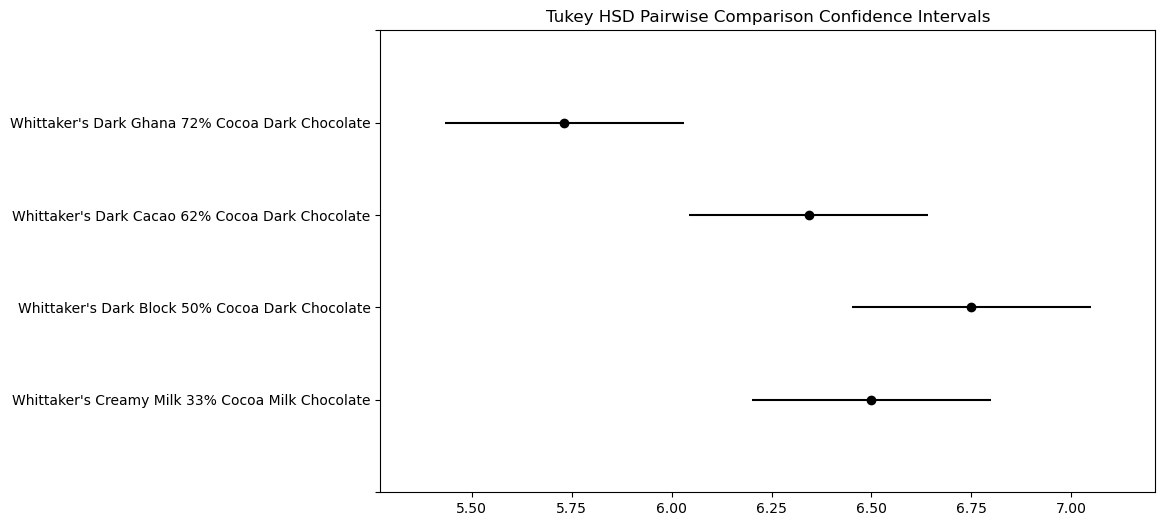

In [210]:
tukey = pairwise_tukeyhsd(endog=df_clean["Aroma"], #endog means endogenous variables.
                          groups=df_clean["Sample_Name"],
                          alpha=0.05)

print("\nTukey HSD results:")
print(tukey.summary())

tukey.plot_simultaneous()
plt.title("Tukey HSD Pairwise Comparison Confidence Intervals")
plt.show()

## Flavour


Tukey HSD results:
                                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                                          
                     group1                                           group2                     meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------------------------------------------------------------------
Whittaker's Creamy Milk 33% Cocoa Milk Chocolate Whittaker's Dark Block 50% Cocoa Dark Chocolate   0.3241 0.6191 -0.3652  1.0133  False
Whittaker's Creamy Milk 33% Cocoa Milk Chocolate Whittaker's Dark Cacao 62% Cocoa Dark Chocolate   0.0278 0.9996 -0.6615   0.717  False
Whittaker's Creamy Milk 33% Cocoa Milk Chocolate Whittaker's Dark Ghana 72% Cocoa Dark Chocolate  -1.1944 0.0001 -1.8837 -0.5052   True
 Whittaker's Dark Block 50% Cocoa Dark Chocolate Whittaker's Dark Cacao 62% Cocoa Dark Chocolate  -0.2963 0.6844 -0.9856   0.393  False
 Whittaker's Dark Block 50% 

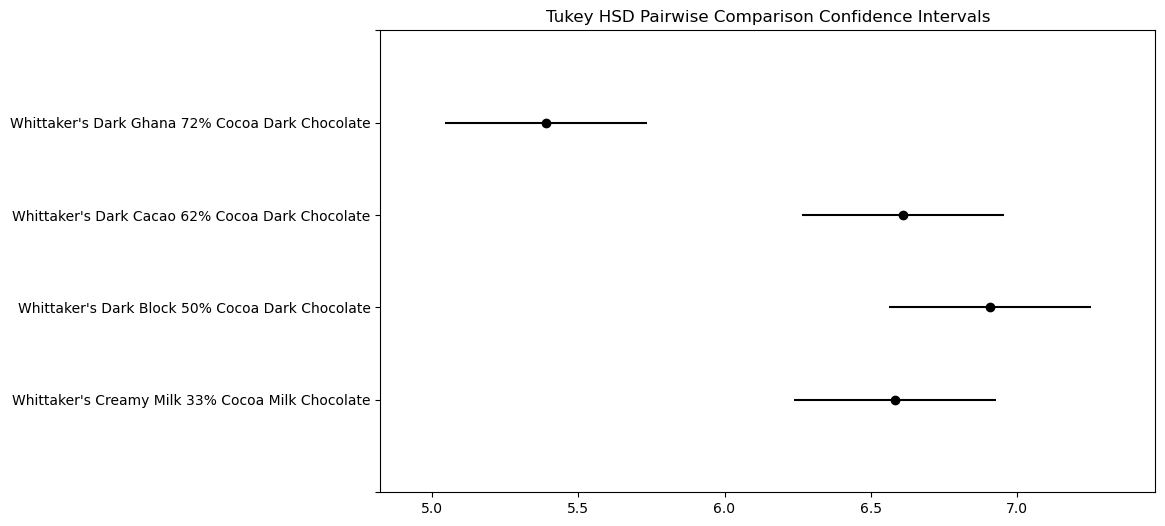

In [211]:
tukey = pairwise_tukeyhsd(endog=df_clean["Flavour"], #endog means endogenous variables.
                          groups=df_clean["Sample_Name"],
                          alpha=0.05)

print("\nTukey HSD results:")
print(tukey.summary())

tukey.plot_simultaneous()
plt.title("Tukey HSD Pairwise Comparison Confidence Intervals")
plt.show()

## Texture


Tukey HSD results:
                                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                                          
                     group1                                           group2                     meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------------------------------------------------------------------
Whittaker's Creamy Milk 33% Cocoa Milk Chocolate Whittaker's Dark Block 50% Cocoa Dark Chocolate  -0.1296  0.941 -0.7162  0.4569  False
Whittaker's Creamy Milk 33% Cocoa Milk Chocolate Whittaker's Dark Cacao 62% Cocoa Dark Chocolate  -0.5093 0.1144 -1.0958  0.0773  False
Whittaker's Creamy Milk 33% Cocoa Milk Chocolate Whittaker's Dark Ghana 72% Cocoa Dark Chocolate  -1.2963    0.0 -1.8828 -0.7098   True
 Whittaker's Dark Block 50% Cocoa Dark Chocolate Whittaker's Dark Cacao 62% Cocoa Dark Chocolate  -0.3796 0.3413 -0.9662  0.2069  False
 Whittaker's Dark Block 50% 

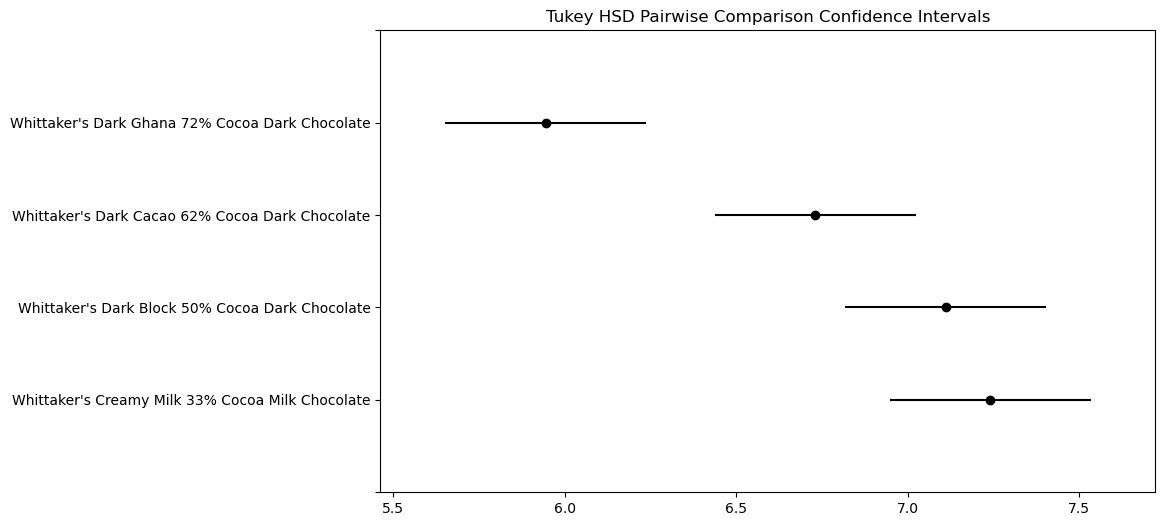

In [212]:
tukey = pairwise_tukeyhsd(endog=df_clean["Texture"], #endog means endogenous variables.
                          groups=df_clean["Sample_Name"],
                          alpha=0.05)

print("\nTukey HSD results:")
print(tukey.summary())

tukey.plot_simultaneous()
plt.title("Tukey HSD Pairwise Comparison Confidence Intervals")
plt.show()

## Aftertaste


Tukey HSD results:
                                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                                          
                     group1                                           group2                     meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------------------------------------------------------------------
Whittaker's Creamy Milk 33% Cocoa Milk Chocolate Whittaker's Dark Block 50% Cocoa Dark Chocolate  -0.0185 0.9999 -0.7403  0.7032  False
Whittaker's Creamy Milk 33% Cocoa Milk Chocolate Whittaker's Dark Cacao 62% Cocoa Dark Chocolate  -0.4537 0.3677 -1.1755  0.2681  False
Whittaker's Creamy Milk 33% Cocoa Milk Chocolate Whittaker's Dark Ghana 72% Cocoa Dark Chocolate    -1.75    0.0 -2.4718 -1.0282   True
 Whittaker's Dark Block 50% Cocoa Dark Chocolate Whittaker's Dark Cacao 62% Cocoa Dark Chocolate  -0.4352 0.4056 -1.1569  0.2866  False
 Whittaker's Dark Block 50% 

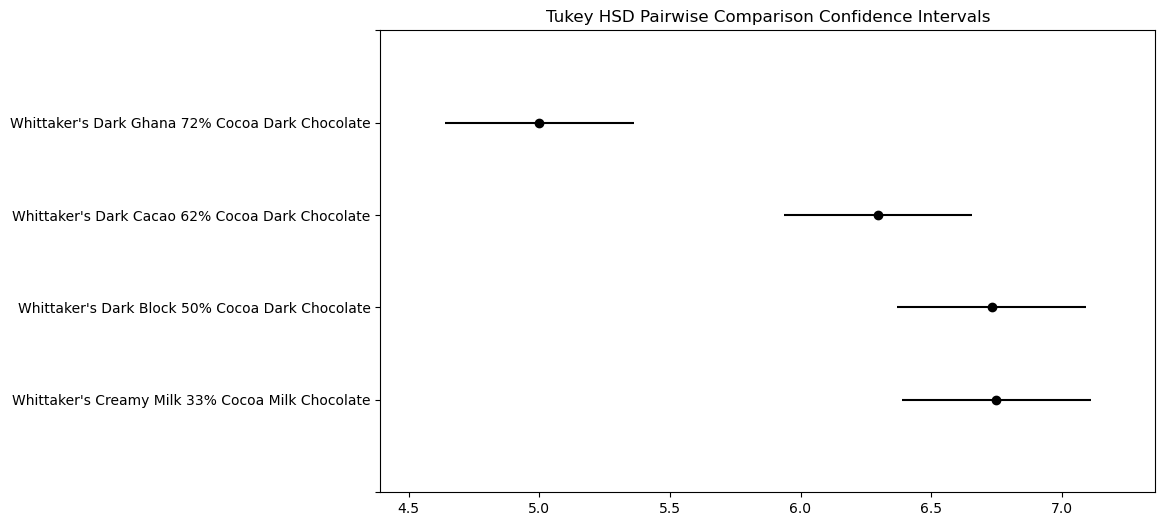

In [213]:
tukey = pairwise_tukeyhsd(endog=df_clean["Aftertaste"], #endog means endogenous variables.
                          groups=df_clean["Sample_Name"],
                          alpha=0.05)

print("\nTukey HSD results:")
print(tukey.summary())

tukey.plot_simultaneous()
plt.title("Tukey HSD Pairwise Comparison Confidence Intervals")
plt.show()

# Barplots for the mean scores of chocolate

## Overall

In [214]:
mc = MultiComparison(df_clean["Overall"], df_clean["Sample_Name"])
tukey_result = mc.tukeyhsd()

In [215]:
# Convert Tukey results to DataFrame
tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], 
                        columns=tukey_result._results_table.data[0])

In [216]:
# Build CLD (Compact Letter Display)
groups = mc.groupsunique
letters = {g: "" for g in groups}

# Start with 'a', 'b', 'c'... etc
alphabet = list("abcdefghijklmnopqrstuvwxyz")
assigned = {g: set() for g in groups}
current_letter = 0

for g in groups:
    if not assigned[g]:  # not assigned yet
        assigned[g].add(alphabet[current_letter])
        # compare with all other groups
        nonsig = tukey_df[
            ((tukey_df['group1'] == g) | (tukey_df['group2'] == g)) & 
            (tukey_df['reject'] == False)
        ]
        for _, row in nonsig.iterrows():
            other = row['group2'] if row['group1'] == g else row['group1']
            assigned[other].add(alphabet[current_letter])
        current_letter += 1

cld = {g: "".join(sorted(v)) for g, v in assigned.items()}
print("CLD:", cld)


CLD: {"Whittaker's Creamy Milk 33% Cocoa Milk Chocolate": 'a', "Whittaker's Dark Block 50% Cocoa Dark Chocolate": 'a', "Whittaker's Dark Cacao 62% Cocoa Dark Chocolate": 'a', "Whittaker's Dark Ghana 72% Cocoa Dark Chocolate": 'a'}


In [217]:
# Merge CLD with group means
df_overall["CLD"] = df_overall["Sample_Name"].map(cld)


/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_27287/1986477687.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_27287/1986477687.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


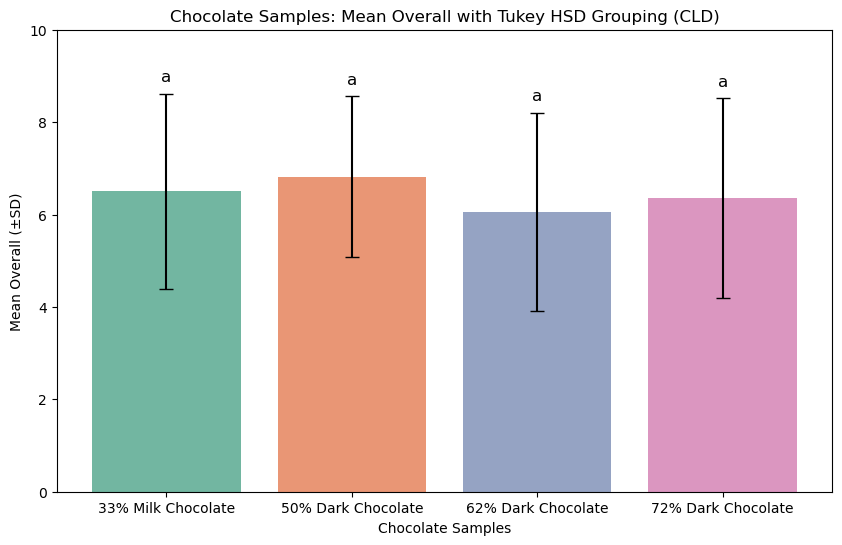

In [218]:

# Plot bars
plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=df_overall,
    x="Short_Name",     
    y="Mean_Overall",   
    palette="Set2",
    ci=None
)

# Add error bars
ax.errorbar(
    x=range(len(df_overall)),
    y=df_overall["Mean_Overall"],
    yerr=df_overall["Std_Overall"],
    fmt="none",
    c="black",
    capsize=5
)

# Add CLD letters above bars
for i, row in df_overall.iterrows():
    ax.text(i, row["Mean_Overall"] + row["Std_Overall"] + 0.2, 
            row["CLD"], ha="center", va="bottom", fontsize=12, color="black")

plt.ylim(0, 10)
plt.title("Chocolate Samples: Mean Overall with Tukey HSD Grouping (CLD)")
plt.ylabel("Mean Overall (±SD)")
plt.xlabel("Chocolate Samples") 
plt.show()

## Aroma

In [219]:
mc = MultiComparison(df_clean["Aroma"], df_clean["Sample_Name"])
tukey_result = mc.tukeyhsd()

tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], 
                        columns=tukey_result._results_table.data[0])

groups = mc.groupsunique
letters = {g: "" for g in groups}

# Start with 'a', 'b', 'c'... etc
alphabet = list("abcdefghijklmnopqrstuvwxyz")
assigned = {g: set() for g in groups}
current_letter = 0

for g in groups:
    if not assigned[g]:  # not assigned yet
        assigned[g].add(alphabet[current_letter])
        # compare with all other groups
        nonsig = tukey_df[
            ((tukey_df['group1'] == g) | (tukey_df['group2'] == g)) & 
            (tukey_df['reject'] == False)
        ]
        for _, row in nonsig.iterrows():
            other = row['group2'] if row['group1'] == g else row['group1']
            assigned[other].add(alphabet[current_letter])
        current_letter += 1

cld = {g: "".join(sorted(v)) for g, v in assigned.items()}
print("CLD:", cld)

df_aroma["CLD"] = df_aroma["Sample_Name"].map(cld)



CLD: {"Whittaker's Creamy Milk 33% Cocoa Milk Chocolate": 'a', "Whittaker's Dark Block 50% Cocoa Dark Chocolate": 'a', "Whittaker's Dark Cacao 62% Cocoa Dark Chocolate": 'a', "Whittaker's Dark Ghana 72% Cocoa Dark Chocolate": 'b'}


/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_27287/344634996.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_27287/344634996.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


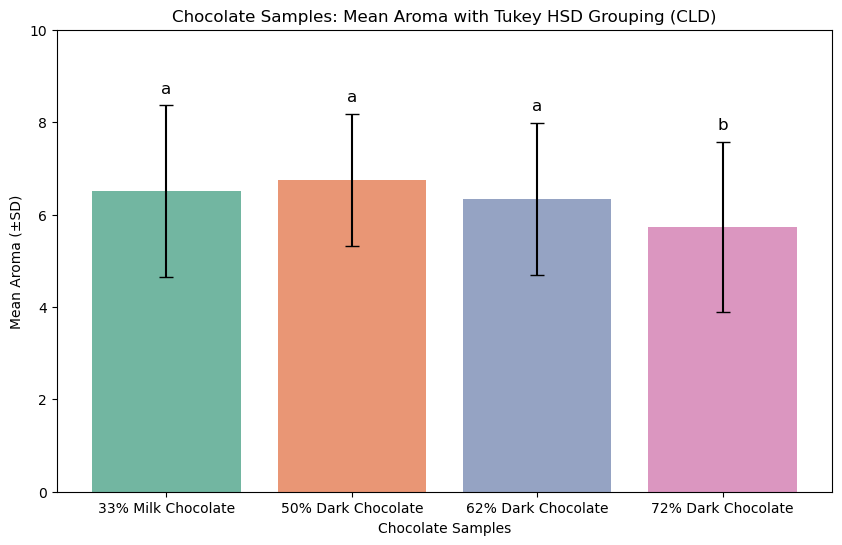

In [220]:
# Plot bars
plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=df_aroma,
    x="Short_Name",     
    y="Mean_Aroma",   
    palette="Set2",
    ci=None
)

# Add error bars
ax.errorbar(
    x=range(len(df_aroma)),
    y=df_aroma["Mean_Aroma"],
    yerr=df_aroma["Std_Aroma"],
    fmt="none",
    c="black",
    capsize=5
)

# Add CLD letters above bars
for i, row in df_aroma.iterrows():
    ax.text(i, row["Mean_Aroma"] + row["Std_Aroma"] + 0.2, 
            row["CLD"], ha="center", va="bottom", fontsize=12, color="black")

plt.ylim(0, 10)
plt.title("Chocolate Samples: Mean Aroma with Tukey HSD Grouping (CLD)")
plt.ylabel("Mean Aroma (±SD)")
plt.xlabel("Chocolate Samples") 
plt.show()

## Flavour

In [221]:
mc = MultiComparison(df_clean["Flavour"], df_clean["Sample_Name"])
tukey_result = mc.tukeyhsd()

tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], 
                        columns=tukey_result._results_table.data[0])

groups = mc.groupsunique
letters = {g: "" for g in groups}

# Start with 'a', 'b', 'c'... etc
alphabet = list("abcdefghijklmnopqrstuvwxyz")
assigned = {g: set() for g in groups}
current_letter = 0

for g in groups:
    if not assigned[g]:  # not assigned yet
        assigned[g].add(alphabet[current_letter])
        # compare with all other groups
        nonsig = tukey_df[
            ((tukey_df['group1'] == g) | (tukey_df['group2'] == g)) & 
            (tukey_df['reject'] == False)
        ]
        for _, row in nonsig.iterrows():
            other = row['group2'] if row['group1'] == g else row['group1']
            assigned[other].add(alphabet[current_letter])
        current_letter += 1

cld = {g: "".join(sorted(v)) for g, v in assigned.items()}
print("CLD:", cld)

df_flavour["CLD"] = df_flavour["Sample_Name"].map(cld)

CLD: {"Whittaker's Creamy Milk 33% Cocoa Milk Chocolate": 'a', "Whittaker's Dark Block 50% Cocoa Dark Chocolate": 'a', "Whittaker's Dark Cacao 62% Cocoa Dark Chocolate": 'a', "Whittaker's Dark Ghana 72% Cocoa Dark Chocolate": 'b'}


/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_27287/1008516712.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_27287/1008516712.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


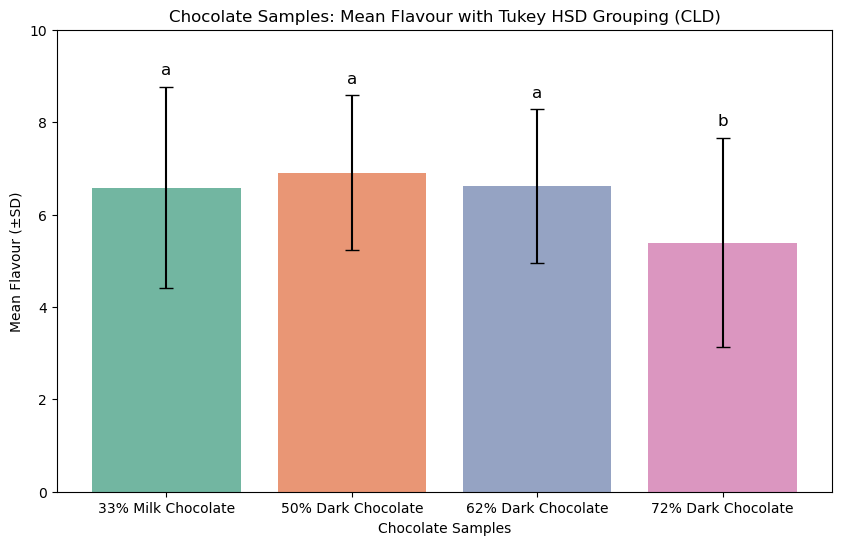

In [222]:
# Plot bars
plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=df_flavour,
    x="Short_Name",     
    y="Mean_Flavour",   
    palette="Set2",
    ci=None
)

# Add error bars
ax.errorbar(
    x=range(len(df_flavour)),
    y=df_flavour["Mean_Flavour"],
    yerr=df_flavour["Std_Flavour"],
    fmt="none",
    c="black",
    capsize=5
)

# Add CLD letters above bars
for i, row in df_flavour.iterrows():
    ax.text(i, row["Mean_Flavour"] + row["Std_Flavour"] + 0.2, 
            row["CLD"], ha="center", va="bottom", fontsize=12, color="black")

plt.ylim(0, 10)
plt.title("Chocolate Samples: Mean Flavour with Tukey HSD Grouping (CLD)")
plt.ylabel("Mean Flavour (±SD)")
plt.xlabel("Chocolate Samples") 
plt.show()

## Texture

In [223]:
mc = MultiComparison(df_clean["Texture"], df_clean["Sample_Name"])
tukey_result = mc.tukeyhsd()

tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], 
                        columns=tukey_result._results_table.data[0])

groups = mc.groupsunique
letters = {g: "" for g in groups}

# Start with 'a', 'b', 'c'... etc
alphabet = list("abcdefghijklmnopqrstuvwxyz")
assigned = {g: set() for g in groups}
current_letter = 0

for g in groups:
    if not assigned[g]:  # not assigned yet
        assigned[g].add(alphabet[current_letter])
        # compare with all other groups
        nonsig = tukey_df[
            ((tukey_df['group1'] == g) | (tukey_df['group2'] == g)) & 
            (tukey_df['reject'] == False)
        ]
        for _, row in nonsig.iterrows():
            other = row['group2'] if row['group1'] == g else row['group1']
            assigned[other].add(alphabet[current_letter])
        current_letter += 1

cld = {g: "".join(sorted(v)) for g, v in assigned.items()}
print("CLD:", cld)

df_texture["CLD"] = df_texture["Sample_Name"].map(cld)

CLD: {"Whittaker's Creamy Milk 33% Cocoa Milk Chocolate": 'a', "Whittaker's Dark Block 50% Cocoa Dark Chocolate": 'a', "Whittaker's Dark Cacao 62% Cocoa Dark Chocolate": 'a', "Whittaker's Dark Ghana 72% Cocoa Dark Chocolate": 'b'}


/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_27287/2320534646.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_27287/2320534646.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


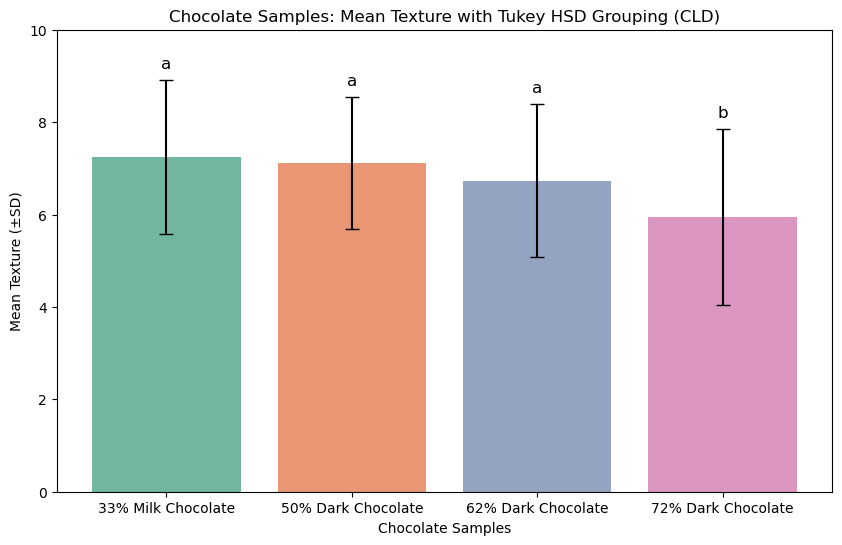

In [224]:
# Plot bars
plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=df_texture,
    x="Short_Name",     
    y="Mean_Texture",   
    palette="Set2",
    ci=None
)

# Add error bars
ax.errorbar(
    x=range(len(df_texture)),
    y=df_texture["Mean_Texture"],
    yerr=df_texture["Std_Texture"],
    fmt="none",
    c="black",
    capsize=5
)

# Add CLD letters above bars
for i, row in df_texture.iterrows():
    ax.text(i, row["Mean_Texture"] + row["Std_Texture"] + 0.2, 
            row["CLD"], ha="center", va="bottom", fontsize=12, color="black")

plt.ylim(0, 10)
plt.title("Chocolate Samples: Mean Texture with Tukey HSD Grouping (CLD)")
plt.ylabel("Mean Texture (±SD)")
plt.xlabel("Chocolate Samples") 
plt.show()

## Aftertaste

In [225]:
mc = MultiComparison(df_clean["Aftertaste"], df_clean["Sample_Name"])
tukey_result = mc.tukeyhsd()

tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], 
                        columns=tukey_result._results_table.data[0])

groups = mc.groupsunique
letters = {g: "" for g in groups}

# Start with 'a', 'b', 'c'... etc
alphabet = list("abcdefghijklmnopqrstuvwxyz")
assigned = {g: set() for g in groups}
current_letter = 0

for g in groups:
    if not assigned[g]:  # not assigned yet
        assigned[g].add(alphabet[current_letter])
        # compare with all other groups
        nonsig = tukey_df[
            ((tukey_df['group1'] == g) | (tukey_df['group2'] == g)) & 
            (tukey_df['reject'] == False)
        ]
        for _, row in nonsig.iterrows():
            other = row['group2'] if row['group1'] == g else row['group1']
            assigned[other].add(alphabet[current_letter])
        current_letter += 1

cld = {g: "".join(sorted(v)) for g, v in assigned.items()}
print("CLD:", cld)

df_aftertaste["CLD"] = df_aftertaste["Sample_Name"].map(cld)

CLD: {"Whittaker's Creamy Milk 33% Cocoa Milk Chocolate": 'a', "Whittaker's Dark Block 50% Cocoa Dark Chocolate": 'a', "Whittaker's Dark Cacao 62% Cocoa Dark Chocolate": 'a', "Whittaker's Dark Ghana 72% Cocoa Dark Chocolate": 'b'}


/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_27287/1664938259.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_27287/1664938259.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


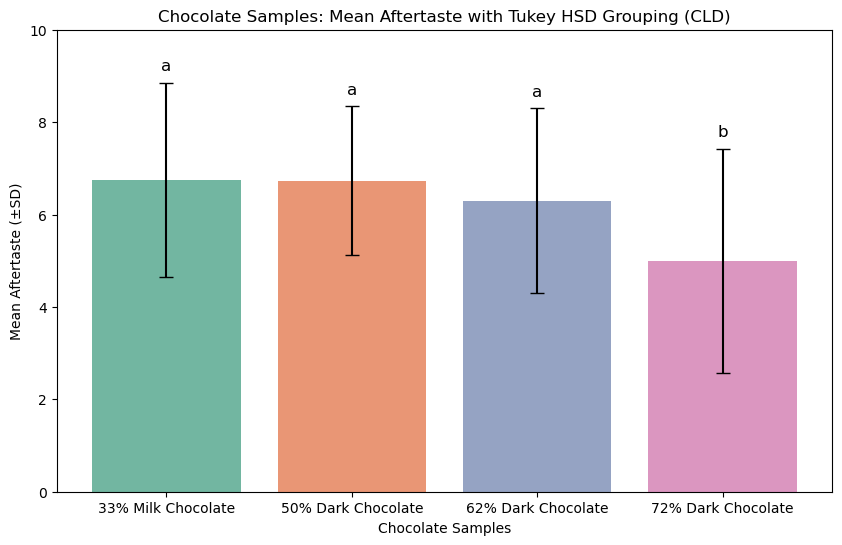

In [226]:
# Plot bars
plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=df_aftertaste,
    x="Short_Name",     
    y="Mean_Aftertaste",   
    palette="Set2",
    ci=None
)

# Add error bars
ax.errorbar(
    x=range(len(df_aftertaste)),
    y=df_aftertaste["Mean_Aftertaste"],
    yerr=df_aftertaste["Std_Aftertaste"],
    fmt="none",
    c="black",
    capsize=5
)

# Add CLD letters above bars
for i, row in df_aftertaste.iterrows():
    ax.text(i, row["Mean_Aftertaste"] + row["Std_Aftertaste"] + 0.2, 
            row["CLD"], ha="center", va="bottom", fontsize=12, color="black")

plt.ylim(0, 10)
plt.title("Chocolate Samples: Mean Aftertaste with Tukey HSD Grouping (CLD)")
plt.ylabel("Mean Aftertaste (±SD)")
plt.xlabel("Chocolate Samples") 
plt.show()

# Lineplot

In [227]:
df_clean["Short_Name"] = df_clean["Sample_Name"].map(name_map)

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_27287/722770688.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(
/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_27287/722770688.py:9: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


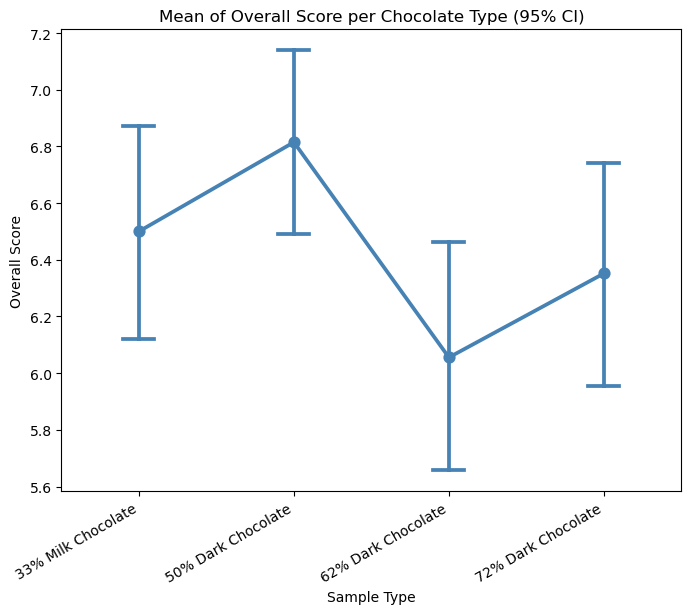

In [228]:

model = sm.formula.ols("Overall ~ C(Sample_Name)", data=df_clean).fit()

# Get means and confidence intervals
means = model.params
conf_int = model.conf_int()

# Or easier: use seaborn's pointplot to show mean ± CI
plt.figure(figsize=(8, 6))
sns.pointplot(
    data=df_clean,
    x="Short_Name",
    y="Overall",
    ci=95,         # 95% confidence interval
    join=True,    # don't join with a line
    capsize=0.2,   # add caps to error bars
    color="steelblue"
)

plt.title("Mean of Overall Score per Chocolate Type (95% CI)")
plt.xlabel("Sample Type")
plt.ylabel("Overall Score")
plt.xticks(rotation=30, ha="right")
plt.show()

# Eating Chocolate

## Data cleaning

In [229]:
file_path = "Eating Chocolate.xlsx"
df_eat = pd.read_excel(file_path)  

In [230]:
print(df_eat.columns.tolist())

['Participant Info', 'Q1: Single Selection', 'Q2: Single Selection']


In [231]:
df_eat.head(15)

,Participant Info,Q1: Single Selection,Q2: Single Selection
0,NaN,Do you eat chocolate products?,How often do you eat chocolate products?
1,NaN,1=Yes\n2=No,1=Everyday\n2=2-4 times a week\n3=Once a week\...
2,Participant Code,Do you eat chocolate products?,How often do you eat chocolate products?
3,1002,1,4
4,1003,1,3
5,1004,1,4
6,1005,1,4
7,1006,1,6
8,1007,1,1
9,1008,1,4


In [232]:
# Drop rows 0 to 2
df_eat = df_eat.drop(index=range(0, 3)).reset_index(drop=True)

# Rename columns
df_eat = df_eat.rename(columns={
    "Q1: Single Selection": "Do you eat chocolate products?",
    "Q2: Single Selection": "How often do you eat chocolate products?"
})

# Optional: check the first few rows
df_eat.head()

,Participant Info,Do you eat chocolate products?,How often do you eat chocolate products?
0,1002,1,4
1,1003,1,3
2,1004,1,4
3,1005,1,4
4,1006,1,6


In [233]:
unique_count = df_eat["Participant Info"].nunique()
print("Number of unique participants:", unique_count)


Number of unique participants: 141


In [234]:
# List of participant codes to drop
codes_to_drop = [1033, 1118, 1126, 1128, 2005, 2013, 2018, 2019, 2020, 2025, 2029, 2030, 2034, 2035, 2036]

# Keep only rows where Participant Code is NOT in the list
df_eat = df_eat[~df_eat["Participant Info"].isin(codes_to_drop)]

# Optional: check how many rows remain
print("Number of remaining participants:", df_eat["Participant Info"].nunique())

Number of remaining participants: 126


In [235]:
# Get unique codes from each DataFrame
codes_clean = df_clean["Participant Code"].unique()
codes_eat = df_eat["Participant Info"].unique()

# Check for codes in df_clean not in df_eat
unmatched_in_eat = set(codes_clean) - set(codes_eat)

# Check for codes in df_eat not in df_clean
unmatched_in_clean = set(codes_eat) - set(codes_clean)

# Print results
if not unmatched_in_eat and not unmatched_in_clean:
    print("All participant codes match perfectly!")
else:
    if unmatched_in_eat:
        print("Codes in df_clean not in df_eat:", unmatched_in_eat)
    if unmatched_in_clean:
        print("Codes in df_eat not in df_clean:", unmatched_in_clean)

Codes in df_eat not in df_clean: {1122, 1123, 1060, 1125, 2022, 1097, 1034, 2012, 1038, 2045, 2002, 2037, 2038, 1109, 2041, 2044, 1117, 2014}


In [236]:
counts = df_eat["Do you eat chocolate products?"].value_counts()

print(counts)

Do you eat chocolate products?
1    124
2      2
Name: count, dtype: int64


In [237]:
# Filter participants who answered 2
participants_with_2 = df_eat[df_eat["Do you eat chocolate products?"] == 2]

# Show their participant info codes
print(participants_with_2["Participant Info"].tolist())

[1034, 2014]


## Pie charts

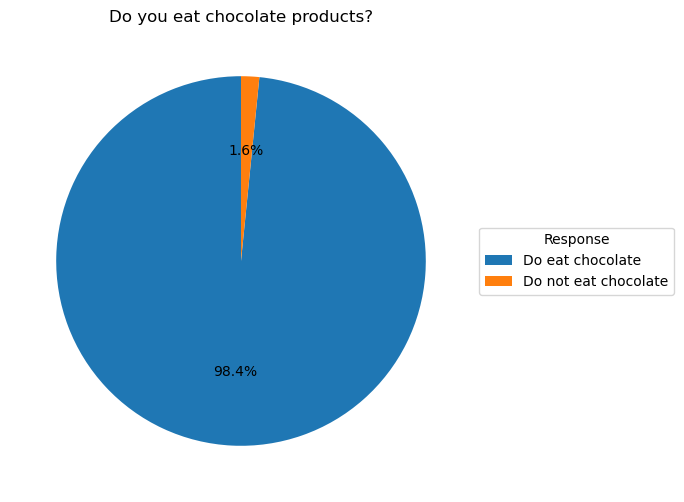

In [238]:
# Count values of 1 and 2
counts = df_eat["Do you eat chocolate products?"].value_counts()

# Label mapping
label_map = {1: "Do eat chocolate", 2: "Do not eat chocolate"}

# Draw pie chart
plt.figure(figsize=(6,6))
wedges, texts, autotexts= plt.pie(
    counts, 
    labels=None, 
    autopct='%1.1f%%', 
    startangle=90
)
plt.legend(
    wedges,
    [label_map[i] for i in counts.index],
    title="Response",
    loc="center left",
    bbox_to_anchor=(1, 0.5)   # Push legend to the right side
)

plt.title("Do you eat chocolate products?")
plt.show()


## How often do you eat chocolate products?

In [239]:
df_eat.head()

,Participant Info,Do you eat chocolate products?,How often do you eat chocolate products?
0,1002,1,4
1,1003,1,3
2,1004,1,4
3,1005,1,4
4,1006,1,6


In [240]:
print(df_eat["How often do you eat chocolate products?"].unique())

# Theres no '5' response showing because, participant 2013 and 2025 were dropped due to incomplete submission of the hedonic test.

[4 3 6 1 2]


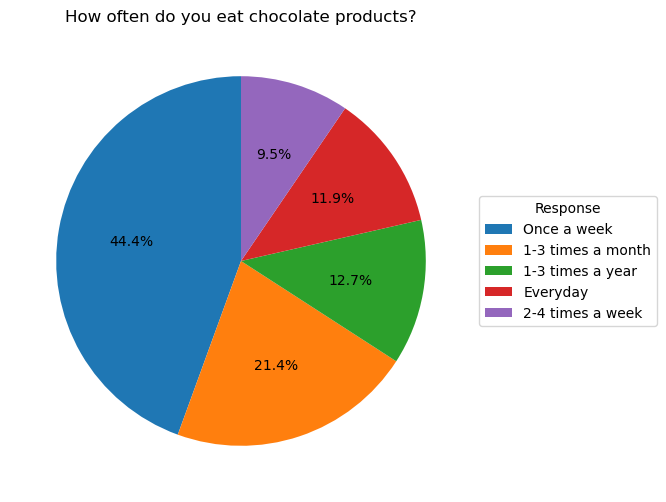

In [241]:
# Count values of 1 and 2
counts = df_eat["How often do you eat chocolate products?"].value_counts()

# Label mapping
label_map = {1: "Everyday", 2: "2-4 times a week", 3: "Once a week", 4: "1-3 times a month", 5: "1-2 times a season", 6: "1-3 times a year", 7: "Less than once a year", 8: "Never"}

# Draw pie chart
plt.figure(figsize=(6,6))
wedges, texts, autotexts= plt.pie(
    counts, 
    labels=None, 
    autopct='%1.1f%%', 
    startangle=90
)
plt.legend(
    wedges,
    [label_map[i] for i in counts.index],
    title="Response",
    loc="center left",
    bbox_to_anchor=(1, 0.5)   # Push legend to the right side
)

plt.title("How often do you eat chocolate products?")
plt.show()
